# iFreeETF FANG+ 日足

In [4]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [5]:
pattern = re.compile(r'(.+)\.T')

symbol = '316A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1y')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-03-05 00:00:00+09:00,1742.0,1743.0,1730.0,1735.0,877572,0.0,0.0,0.0
2025-03-06 00:00:00+09:00,1740.0,1746.0,1736.0,1739.0,472099,0.0,0.0,0.0
2025-03-07 00:00:00+09:00,1686.0,1687.0,1672.0,1677.0,1395738,0.0,0.0,0.0
2025-03-10 00:00:00+09:00,1643.0,1653.0,1637.0,1647.0,1460534,0.0,0.0,0.0
2025-03-11 00:00:00+09:00,1558.0,1585.0,1537.0,1581.0,2186102,0.0,0.0,0.0


## 日足チャートとパラボリック SAR

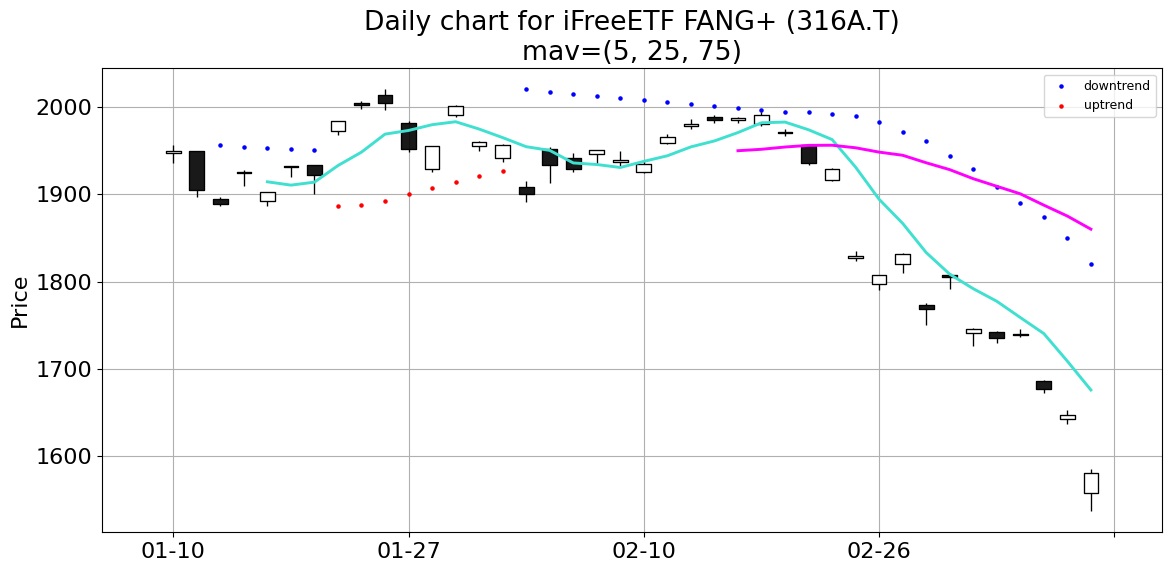

In [6]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='best', fontsize=9)


plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [7]:
df.tail(2)['Close']

Date
2025-03-10 00:00:00+09:00    1647.0
2025-03-11 00:00:00+09:00    1581.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-02-25 00:00:00+09:00     NaN
2025-02-26 00:00:00+09:00   -22.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-02-25 00:00:00+09:00    1931.0
2025-02-26 00:00:00+09:00    1894.2
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-02-25 00:00:00+09:00    1953.16
2025-02-26 00:00:00+09:00    1948.20
Name: Close, dtype: float64

In [20]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-02-21 00:00:00+09:00   NaN
2025-02-25 00:00:00+09:00   NaN
Name: Close, dtype: float64